In [1]:
import os
os.chdir('../..')


In [2]:
from classes.helpers import *
import numpy as np
import json
import pandas as pd
import scipy.stats as ss
from sklearn import linear_model
import ast
import scipy.stats as ss


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

from scipy.optimize import minimize

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

data_folder = '../data/'
save_folder = '../figures/all/4-herding/'

colors = {'H for (H-H)': '#8b0000',
          'H for (H-L)': '#c1253d',
          'H for (H-M)': '#e75c59',
          'M for (H-M)': '#fe9755',
          'M for (M-M)': '#ffd700',
          'M for (L-M)': '#9dcd75',
          'L for (L-M)': '#6cb482',
          'L for (H-L)': '#419a83',
          'L for (L-L)': '#008080',
          'ba': (232/255,164/255,29/255), 
          'rb': (0/255,152/255,205/255)}

min_nbr_rats = 5

# Choose example

In [3]:
beer_id_ba = 78599

# Load DF

In [4]:
df = pd.read_csv(data_folder + 'tmp/time_series_{}_ranks.csv'.format(min_nbr_rats), header=[0,1])

# Transform strings into arrays
for i in df.index:
    for key1 in ['ba', 'rb']:
        for key2 in ['dates', 'ratings', 'z_scores', 'ranks']:
            arr = ast.literal_eval(df.loc[i][key1][key2])
            df.set_value(i, (key1, key2), arr)

In [5]:
diffs = {'ba': [], 'rb': []}

for key in diffs.keys():
    for i in df.index:
        row = df.iloc[i]
        diffs[key].append(row[key]['z_scores'][0])

thresholds = {}

for key in ['ba', 'rb']:
    thresholds[key] = {}
    thresholds[key]['low'] = np.percentile(diffs[key], 15)
    thresholds[key]['high'] = np.percentile(diffs[key], 85)

# Histogram 1D

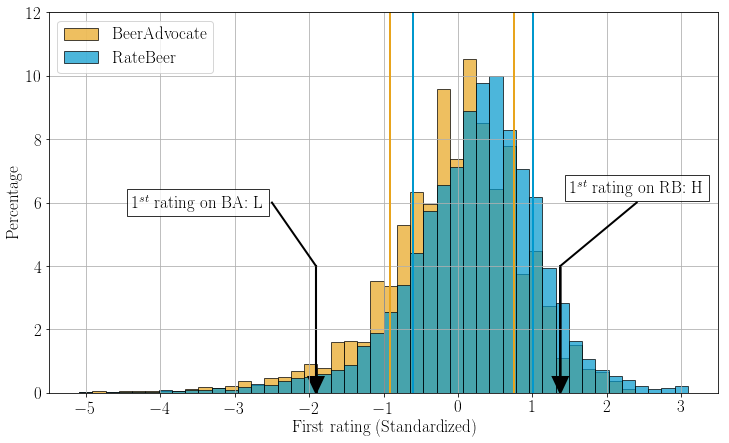

In [24]:
labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

nbr_bins = 45

bin_edges = {'ba': None, 'rb': None}
hist = {'ba': None, 'rb': None}

for key in labels.keys():
    a, bin_edges[key] = np.histogram(diffs[key], range=(-5, 3), bins=nbr_bins)
    hist[key], a = np.histogram(diffs[key], range=(-5, 3), bins=nbr_bins+1)
    hist[key] = hist[key]/np.sum(hist[key])*100

plt.figure(figsize=(12,7))
plt.rc('font', family='serif')
plt.rc('font', size=17)

for key in hist.keys():
    width = bin_edges[key][1] - bin_edges[key][0]
    plt.bar(bin_edges[key], hist[key], width = width, facecolor=colors[key], edgecolor='k', alpha=0.7, label=labels[key])

max_ = 12

plt.grid()
plt.legend(loc=2)
plt.ylim([0, max_])

for key in labels.keys():        
    plt.plot([thresholds[key]['low'], thresholds[key]['low']], [0, max_], color=colors[key], linewidth=2)
    plt.plot([thresholds[key]['high'], thresholds[key]['high']], [0, max_], color=colors[key], linewidth=2)

plt.ylabel('Percentage')
plt.xlabel('First rating (Standardized)')

# Show the value of the example

subdf = df[df['ba']['beer_id'] == beer_id_ba]
ba = np.array(subdf['ba']['z_scores'])[0][0]
rb = np.array(subdf['rb']['z_scores'])[0][0]

plt.arrow(ba, 4, 0, -3.5, linewidth=2, head_width=0.2, head_length=0.5, fc='k', ec='k')
plt.plot([ba, -2.5], [4, 6], 'k', linewidth=2)
plt.text(-2.5-0.1, 6, '1$^{st}$ rating on BA: L', 
         horizontalalignment='right', verticalalignment='center',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

plt.arrow(rb, 4, 0, -3.5, linewidth=2, head_width=0.2, head_length=0.5, fc='k', ec='k')
plt.plot([rb, 2.4], [4, 6], 'k', linewidth=2)
plt.text(2.4, 6+0.2, '1$^{st}$ rating on RB: H', 
         horizontalalignment='center', verticalalignment='bottom',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})


plt.savefig(save_folder + 'hist_first_rat_example.pdf', bbox_inches='tight')

# Bootstrap

In [9]:
np.random.seed(1)

classes_to_study = ['H-H', 'L-L', 'M-M', 'L-M', 'H-L', 'H-M']

nbr_draws = 1000

vals = {}

# Go through all the classes
for cl in classes_to_study:
    
    if cl[0] != cl[-1]:
        # Take care of first class
        
        classes = [cl[0] + ' for (' + cl + ')', cl[-1] + ' for (' + cl + ')']
                
        subdf = df[(((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))) &
                   (df['ba']['nbr_ratings'] >= min_nbr_rats) & (df['rb']['nbr_ratings'] >= min_nbr_rats)] 
        
        for class_ in classes:
            vals[class_] = {'avg': [], 'low': [], 'high': []}
            
            letter = class_[0]
            
            ba = subdf[subdf['ba']['class'] == letter]['ba']
            ba.index = range(len(ba))
            rb = subdf[subdf['rb']['class'] == letter]['rb']
            rb.index = range(len(rb))
            
            nbr = min(len(ba), len(rb))
            
            ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
            ba.index = range(len(ba))
            
            rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
            rb.index = range(len(rb))
        
            # Go through all the ratings
            for i in range(min_nbr_rats):
                

                vals_ba = np.array([r[i] for r in ba['z_scores']])
                vals_rb = np.array([r[i] for r in rb['z_scores']])

                tmp = []
                # Go through each draw
                for d in range(nbr_draws):
                    
                    # Get the indices
                    idx_ba = np.random.randint(0, len(ba), nbr)
                    idx_rb = np.random.randint(0, len(rb), nbr)
                    
                    vals_tmp = vals_ba[idx_ba]
                    vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])
                                        
                    tmp.append(np.mean(vals_tmp))
                    
                avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
                vals[class_]['avg'].append(avg)
                vals[class_]['low'].append(np.percentile(tmp, 2.5))
                vals[class_]['high'].append(np.percentile(tmp, 97.5))            
        
    else:
        
        class_ = cl[0] + ' for (' + cl + ')'
        vals[class_] = {'avg': [], 'low': [], 'high': []}
        
        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0]) &
                   (df['ba']['nbr_ratings'] >= min_nbr_rats) & (df['rb']['nbr_ratings'] >= min_nbr_rats)]

        # Go through all the ratings
        for i in range(min_nbr_rats):

            vals_both = np.array([r[i] for r in subdf['ba']['z_scores']])
            vals_both = np.append(vals_both, np.array([r[i] for r in subdf['rb']['z_scores']]))

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):
                
                indices = np.random.randint(0, len(vals_both), len(vals_both))
                
                vals_tmp = vals_both[indices]
                
                tmp.append(np.mean(vals_tmp))
            
            vals[class_]['avg'].append(np.mean(vals_both))
            vals[class_]['low'].append(np.percentile(tmp, 2.5))
            vals[class_]['high'].append(np.percentile(tmp, 97.5))

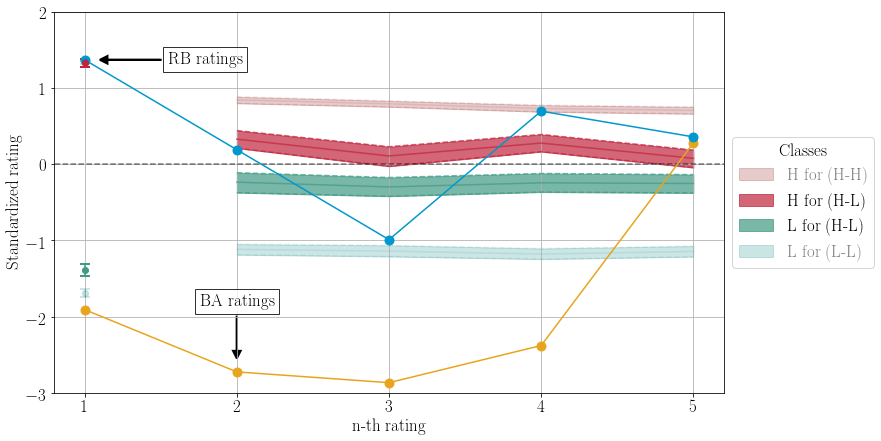

In [53]:
plt.figure(figsize=(12, 7))
plt.grid()

plt.rc('font', family='serif')
plt.rc('font', size=17)

ax = plt.subplot(111)

classes_to_plot = ['H for (H-H)','H for (H-L)', 'L for (H-L)', 'L for (L-L)']

vals_class = [0, 3]

i = 0
for class_ in classes_to_plot:

    vals_tmp = vals[class_]

    avg = np.array(vals_tmp['avg'])
    high = np.array(vals_tmp['high'])
    low = np.array(vals_tmp['low'])

    if i in vals_class:
        alpha = 0.2
    else:
        alpha = 1

    plt.errorbar(1, avg[0], yerr=[[high[0]-avg[0]], [avg[0]-low[0]]],
                fmt='o', capsize=5, capthick=2, c=colors[class_], alpha=alpha)

    avg = avg[1:]
    high = high[1:]
    low = low[1:]

    if i in vals_class:
        alpha = 0.1
    else:
        alpha = 0.7

    plt.plot(range(2, min_nbr_rats + 1), avg, color=colors[class_], alpha=alpha)
    plt.plot(range(2, min_nbr_rats + 1), high, '--', color=colors[class_], alpha=alpha)
    plt.plot(range(2, min_nbr_rats + 1), low, '--', color=colors[class_], alpha=alpha)

    if i in vals_class:
        alpha = 0.2
    else:
        alpha = 0.7
    plt.fill_between(range(2, min_nbr_rats + 1), low, high, color=colors[class_], alpha=alpha, label = class_) 

    i+=1
    
l = plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(list(range(1,min_nbr_rats + 1)))

i = 0
for text in l.get_texts():
    if i in vals_class:
        text.set_color('gray')
    i+=1

plt.plot([-2, min_nbr_rats + 2], [0, 0], '--k', alpha=0.5)

plt.ylim([-3, 2])
plt.ylabel('Standardized rating')

plt.xlim([0.8, min_nbr_rats + 0.2])

plt.xlabel('n-th rating')
    
# Show the value of the example

subdf = df[df['ba']['beer_id'] == beer_id_ba]
ba = np.array(subdf['ba']['z_scores'])[0][:5]
rb = np.array(subdf['rb']['z_scores'])[0][:5]

plt.plot(range(1, 6), ba, 'o-', color=colors['ba'], ms=9)
plt.arrow(2, -2, 0, -0.45, linewidth=2, head_width=0.05, 
          head_length=0.1, fc='k', ec='k')
plt.text(2, -2+0.1, 'BA ratings', 
         horizontalalignment='center', verticalalignment='bottom',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

plt.plot(range(1, 6), rb, 'o-', color=colors['rb'], ms=9)
plt.arrow(1.5, 1.374, -0.35, 0, linewidth=2, head_width=0.1, 
          head_length=0.05, fc='k', ec='k')
plt.text(1.5+0.05, 1.374, 'RB ratings', 
         horizontalalignment='left', verticalalignment='center',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})


plt.savefig(save_folder + 'herding_{}_example.pdf'.format(type_class), bbox_inches='tight')

# Long-term average

In [54]:
classes_to_study = ['H-H', 'H-L', 'L-L', 'H-M', 'M-M', 'L-M']

np.random.seed(1)

nbr_draws = 1000

min_nbr_ratings = 20

classes_names = []
vals_lta = {'avg': [], 'low': [], 'high': []}

# Go through all the classes
for cl in classes_to_study:

    if cl[0] != cl[-1]:
        # Take care of first class

        if cl == 'L-M':
            classes = [cl[-1] + ' for (' + cl + ')', cl[0] + ' for (' + cl + ')']
        else:
            classes = [cl[0] + ' for (' + cl + ')', cl[-1] + ' for (' + cl + ')']

        subdf = df[((df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[-1])) | 
                   ((df['ba']['class'] == cl[-1]) & (df['rb']['class'] == cl[0]))] 
        subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]

        for class_ in classes:
            classes_names.append(class_)

            letter = class_[0]

            ba = subdf[subdf['ba']['class'] == letter]['ba']
            ba.index = range(len(ba))
            rb = subdf[subdf['rb']['class'] == letter]['rb']
            rb.index = range(len(rb))

            nbr = min(len(ba), len(rb))

            ba = ba.loc[np.random.choice(len(ba), nbr, replace=False)]
            ba.index = range(len(ba))

            rb = rb.loc[np.random.choice(len(rb), nbr, replace=False)]
            rb.index = range(len(rb))

            vals_ba = np.array(ba['avg_z_scores'])
            vals_rb = np.array(rb['avg_z_scores'])

            tmp = []
            # Go through each draw
            for d in range(nbr_draws):

                # Get the indices
                idx_ba = np.random.randint(0, len(ba), nbr)
                idx_rb = np.random.randint(0, len(rb), nbr)

                vals_tmp = vals_ba[idx_ba]
                vals_tmp = np.append(vals_tmp, vals_rb[idx_rb])

                tmp.append(np.mean(vals_tmp))

            avg = (np.mean(vals_ba) + np.mean(vals_rb))/2
            vals_lta['avg'].append(avg)
            vals_lta['low'].append(np.percentile(tmp, 2.5))
            vals_lta['high'].append(np.percentile(tmp, 97.5))            

    else:

        class_ = cl[0] + ' for (' + cl + ')'
        classes_names.append(class_)

        subdf = df[(df['ba']['class'] == cl[0]) & (df['rb']['class'] == cl[0])]

        subdf = subdf[(subdf['ba']['nbr_ratings'] >= min_nbr_ratings) & (subdf['rb']['nbr_ratings'] >= min_nbr_ratings)]

        vals_both = np.array(subdf['ba']['avg_z_scores'])
        vals_both = np.append(vals_both, np.array(subdf['rb']['avg_z_scores']))

        tmp = []
        # Go through each draw
        for d in range(nbr_draws):

            indices = np.random.randint(0, len(vals_both), len(vals_both))

            vals_tmp = vals_both[indices]

            tmp.append(np.mean(vals_tmp))

        vals_lta['avg'].append(np.mean(vals_both))
        vals_lta['low'].append(np.percentile(tmp, 2.5))
        vals_lta['high'].append(np.percentile(tmp, 97.5))  

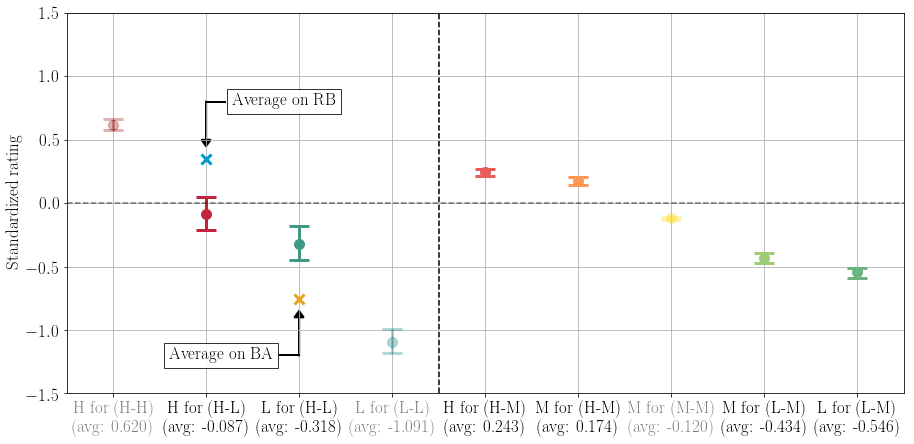

In [85]:
plt.figure(figsize=(15, 7))
plt.grid()

plt.rc('font', family='serif')
plt.rc('font', size=17)

ax = plt.subplot(111)

vals_class = [0, 3, 6]

avg = np.array(vals_lta['avg'])
low = np.array(vals_lta['low'])
high = np.array(vals_lta['high'])

text_ticks = []
for i in range(len(avg)):

    if i in vals_class:
        alpha = 0.3
    else:
        alpha = 1

    plt.errorbar(i, avg[i], yerr=[[high[i]-avg[i]], [avg[i]-low[i]]], 
                fmt='o', markersize=10, capsize=10, capthick=3, lw=3,
                 c=colors[classes_names[i]], alpha=alpha)

    text_ticks.append(classes_names[i] + '\n(avg: {:.3f})'.format(avg[i]))

plt.xlim([-0.5, len(text_ticks)-0.5])
plt.xticks(list(range(len(text_ticks))), text_ticks)

i=0
for xtick in ax.xaxis.get_ticklabels():

    if i in vals_class:
        xtick.set(color='gray')

    i+=1

plt.plot([-0.5, len(text_ticks)-0.5], [0, 0], '--k', alpha=0.5)
plt.plot([3.5, 3.5], [-1.5, 1.5], 'k--')

plt.ylim([-1.5, 1.5])
plt.ylabel('Standardized rating')

# Show the value of the example

subdf = df[df['ba']['beer_id'] == beer_id_ba]
ba = np.array(subdf['ba']['avg_z_scores'])[0]
rb = np.array(subdf['rb']['avg_z_scores'])[0]

plt.plot([1], [rb], 'x', color=colors['rb'], mew=3, ms=10)

plt.arrow(1, 0.8, 0, -0.3, linewidth=2, head_width=0.1, 
          head_length=0.05, fc='k', ec='k')
plt.plot([1, 1.2], [0.8, 0.8], 'k', linewidth=2)
plt.text(1.2+0.08, 0.8, 'Average on RB', 
         horizontalalignment='left', verticalalignment='center',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

plt.plot([2], [ba], 'x', color=colors['ba'], mew=3, ms=10)

plt.arrow(2, -1.2, 0, +0.3, linewidth=2, head_width=0.1, 
          head_length=0.05, fc='k', ec='k')
plt.plot([2, 1.8], [-1.2, -1.2], 'k', linewidth=2)
plt.text(1.8-0.08, -1.2, 'Average on BA', 
         horizontalalignment='right', verticalalignment='center',
        bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

plt.savefig(save_folder + 'lta_herding_example.pdf', bbox_inches='tight')